# LSPIV - Filtering based on Otsu's threshold
*GH Gerritsen*
___
The post-processing as described in the thesis *Flood wave monitoring using LSPIV*, filtering is applied based on the distance of lower values related to the 95th percentile.

This notebook provides a first look into an alternative for this method, based on Otsu's thresholding: values are filtered based on the seperation of bimodal distributions.

The first two sections of this notebook follows the notebook *Part 3 - Post-processing*.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import interpolate, stats

In [2]:
dir_files = 'files'
bat = r'bathymetry.csv'

## Untreated results
Similar to notebook *Part 3 - Post-processing* the x-components of the untreated velocities are provided 

In [3]:
# location of centre bathymetry in imagery. 
# Used to align the flow velocities with the bathymetry
centre_x, centre_y = [8.3471579 , 2.01868403]

# locations stream banks
y0, y1 = [-1.397, 3.785]

# water level (relative to lowest point bathymetry)
wl = 0.9

In [4]:
# import the local bathymetry
bat = r'bathymetry.csv'
df_bat = pd.read_table(bat, sep=';', usecols=['Y', 'H'])

# interpolated function of the bathymetry
func_bat = interpolate.interp1d(df_bat['Y'], df_bat['H'], kind='quadratic')

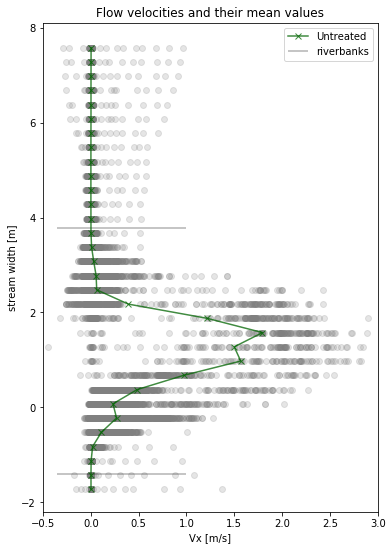

In [5]:
# extract the names of the text files
files = os.listdir(dir_files)

# create a dataframe in which all velocities in the area of interest are stored
vx_all = pd.DataFrame()

# create an array to save the mean velocities 
vx_mean_raw = []

for file in files:
    # import single file and append velocities in area of interest to dataframe
    df = pd.read_table(os.path.join(dir_files, file),
                       sep='\s+',
                       names=('X', 'Y', 'Vx', 'Vy', 's2n'))

    df = df[df['X']>(centre_x - 1)]
    df = df[df['X']<(centre_x + 3)]
    vx_all = vx_all.append(df)

# define the different y coordinates (stream width sections)
y_unique = np.sort(df.Y.unique())
    
# correct y coordinates relative to the bathymetry 'centre'
y_corrected = y_unique - centre_y

fig = plt.figure(figsize=(6,9))
# for each cross-sectional section, find the flow velocities and determine their mean value
for ii, yy in enumerate(y_unique):
    vx = vx_all.Vx[vx_all.Y == yy]
    vx_mean_raw.append(np.mean(vx[np.isfinite(vx)]))
    # show the individual velocities
    plt.scatter(vx, y_corrected[ii]*np.ones(len(vx)), color='grey', marker='o', alpha=0.2)


# show the the mean velocities of the untreated post-processing step
plt.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
plt.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
plt.title('Flow velocities and their mean values')
plt.xlabel('Vx [m/s]')
plt.ylabel('stream width [m]')
plt.xlim(-.5, 3)

plt.legend();

## Original filtering process
The original filtering process is applied when in a cross-sectional section the following statement is met:

$$V_{q95} > 2.5 \cdot \sigma_{V_{X}}$$

In this section, velocities are filtered out when they meet the following statement:

$$V_{X} < V_{q95} - 2 \cdot \sigma_{V_{X}}$$

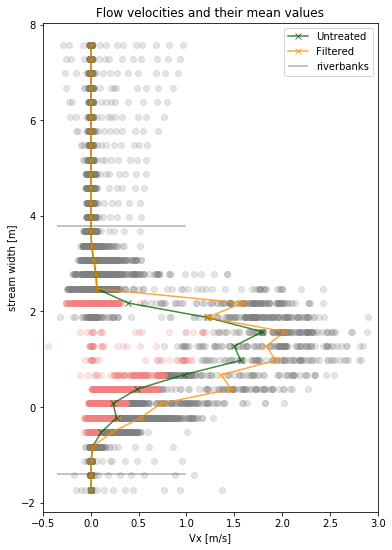

In [6]:
# array to store mean flow velocities
vx_mean_fil = []

fig = plt.figure(figsize=(6,9))

# for each cross section
# find the corresponding flow velocities and remove NaN values
for yy in y_unique:
    vxi = vx_all.Vx[vx_all.Y == yy]
    vxi = vxi[np.isfinite(vxi)]

    # if all values are NaN, create an array with length 1
    if len(vxi) == 0:
        vxi = [0]
    
    # determine the 95th quantile and standard deviation
    v_filter = np.quantile(vxi, 0.95)
    std = np.std(vxi)

    # filtering is applied if the 95th percentile > 2.5*std
    if 2.5*std/v_filter < 1:
        # filtering is applied on values further away than 2*std from the 95th percentile
        vxi_in = vxi[vxi > v_filter - 2*std]
        vxi_out = vxi[vxi < v_filter - 2*std]
        # add mean value based on filtered results
        vx_mean_fil.append(np.mean(vxi_in))

        # plot saved and removed points
        plt.plot(vxi_in, [yy-centre_y]*len(vxi_in), color='grey', linestyle='None', marker='o', zorder=1, alpha=0.2)
        plt.plot(vxi_out, [yy-centre_y]*len(vxi_out), color='lightcoral', linestyle='None', marker='o', zorder=1, alpha=0.2)

    # if filtering is not applied: determine mean over all values
    else:
        vx_mean_fil.append(np.mean(vxi))
        # plt saved points
        plt.plot(vxi, [yy-centre_y]*len(vxi), color='grey', linestyle='None', marker='o', zorder=1, alpha=0.2)

# show the individual velocities and the mean velocities of the untreated and filtered post-processing step
plt.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
plt.plot(vx_mean_fil, y_corrected, color='darkorange', marker='x', zorder=2, alpha=0.75, label='Filtered')
plt.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
plt.title('Flow velocities and their mean values')
plt.xlabel('Vx [m/s]')
plt.ylabel('stream width [m]')
plt.xlim(-.5, 3)

plt.legend();

## Filtering based on Otsu's thresholding
In this section, filtering is applied based on Otsu's thresholding. Otsu's thresholding is usually used to for image thresholding [1]. The algorithm searches for a point where two distributions are seperated by looking for the threshold that minimizes the intra-class variance. This alforithm is provided in the function `otsu`.

As applying this method on each cross-sectional section should be prevented -- i.e. at sections where there is no multi-modality -- an investigation whether a section is unimodal or not should take place. It is tried to use the bimodal coefficient for this. However, this did not have the desired effect. Therefore, currently the skewness of the dataset is used to determine whether filtering is applied or not.

A potential better alternative to investigate the bimodality of a dataset is applying could be applying the hartigan dip test [2]

In [7]:
def BC(data):
    n = len(data)

    # skewness
    m3 = stats.skew(data)

    # excess kurtosis
    m4 = stats.kurtosis(data)

    BC = (m3**2 + 1) / (m4 + 3 * ((n-1)**2) / ((n-2) * (n-3)))
    return BC

def otsu(data, N=1000):
    x = np.linspace(min(data), max(data), N)
    func = stats.gaussian_kde(data)
    
    y = func(x)
    hist_norm = y.ravel()/y.max()
    Q = hist_norm.cumsum()
    
    f_thresh = -1
    f_value = np.inf

    for t in range(1, len(x)-2):
        p1, p2 = np.hsplit(hist_norm, [t])
        q1, q2 = Q[t], Q[-1]-Q[t]
        b1, b2 = np.hsplit(x, [t])
        
        m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
        v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2
        
        fn = v1*q1 + v2*q2
        if fn < f_value:
            f_value = fn
            f_thresh = x[t]
    return f_thresh, f_value

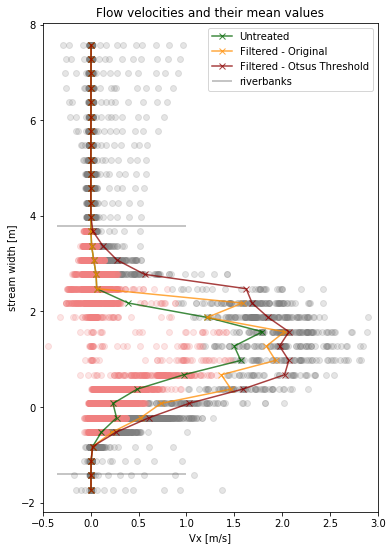

In [8]:
# array to store mean flow velocities
vx_mean_fil_ots = []

fig = plt.figure(figsize=(6,9))
ax1 = plt.subplot(111)

# for each cross section
# find the corresponding flow velocities and remove NaN values
for yy in y_unique:
    vxi = vx_all.Vx[vx_all.Y == yy]
    vxi = vxi[np.isfinite(vxi)]

    # if all values are NaN, create an array with length 1
    if len(vxi) == 0:
        vxi = [0]

    # filtering if applied is the skewness of the dataset is below 10
    if stats.skew(vxi) < 10:
        # determine threshold value otsu's method
        filter_val, __ = otsu(vxi)
        
        # filtering
        vxi_in = vxi[vxi > filter_val]
        vxi_out = vxi[vxi <= filter_val]
        
        # determine mean of filtered results
        vx_mean_fil_ots.append(np.mean(vxi_in))
        
        # plot saved and removed points
        ax1.plot(vxi_in, [yy-centre_y]*len(vxi_in), color='grey', linestyle='None', marker='o', zorder=1, alpha=0.2)
        ax1.plot(vxi_out, [yy-centre_y]*len(vxi_out), color='lightcoral', linestyle='None', marker='o', zorder=1, alpha=0.2)

    # if filtering is not applied: determine mean over all values
    else:
        vx_mean_fil_ots.append(np.mean(vxi))
        # plot saved points
        ax1.plot(vxi, [yy-centre_y]*len(vxi), color='grey', linestyle='None', marker='o', zorder=1, alpha=0.2)

# show the individual velocities and the mean velocities of the untreated and filtered post-processing step
ax1.plot(vx_mean_raw, y_corrected, color='darkgreen', marker='x', zorder=2, alpha=0.75, label='Untreated')
ax1.plot(vx_mean_fil, y_corrected, color='darkorange', marker='x', zorder=2, alpha=0.75, label='Filtered - Original')
ax1.plot(vx_mean_fil_ots, y_corrected, color='darkred', marker='x', zorder=2, alpha=0.75, label='Filtered - Otsus Threshold')
ax1.hlines([y0, y1], xmin=-0.35, xmax=1, color='k', alpha=0.3, label='riverbanks')
ax1.set_title('Flow velocities and their mean values')
ax1.set_xlabel('Vx [m/s]')
ax1.set_ylabel('stream width [m]')
ax1.set_xlim(-.5, 3)

ax1.legend();

___
[1] Otsu's thresholding - https://en.wikipedia.org/wiki/Otsu%27s_method

[2] Hartigan dip test (Hartigan and Hartigan, 1985) - https://projecteuclid.org/download/pdf_1/euclid.aos/1176346577